In [1]:
import numpy as np
from itertools import product
import pandas as pd
import cvxopt
cvxopt.solvers.options['glpk'] = {'tm_lim': 1000} # max timeout for glpk
cvxopt.solvers.options['maxiters'] = 50
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import os
import time 
os.chdir('your file location')
params = {'legend.fontsize':24,
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
pylab.rcParams.update(params)

In [2]:
class soccer:
    def __init__(self): 
        self.field = np.zeros((2,4)) 
    
    def reset(self):
        self.field = np.zeros((2,4)) 
        A = 1
        B = -1
        if np.random.random() < 0.5:
            A = A*2
        else:
            B = B * 2
        PA,PB = np.random.choice([1,2,5,6], size=2, replace=False)
        
        if PA <=3:
            self.field[0][PA] = A
        else:
            self.field[1][PA-4] = A
        if PB <= 3:
            self.field[0][PB] = B
        else:
            self.field[1][PB-4] = B 
        return self.field
    
    def reward(self,state):
        if len(np.where(state == 2)[0]) > 0:
            if state[0][0] == 2 or state[1][0] == 2:
                return 100,-100, True
            elif state[0][3] == 2 or state[1][3] == 2:
                return -100,100,True
            else:
                return 0,0,False
        elif len(np.where(state == -2)[0]) > 0:
            if state[0][0] == -2 or state[1][0] == -2:
                return 100,-100, True
            elif state[0][3] == -2 or state[1][3] == -2:
                return -100,100,True
            else:
                return 0,0,False
            
    def coordinates(self,state,whose):
        if whose == 'A':
            return np.where(state >0)[0][0],np.where(state >0)[1][0]
        elif whose == 'B':
            return np.where(state < 0)[0][0],np.where(state < 0)[1][0]
        
        
    def action_effect(self,state,whose,action,num):
        personal_y, personal_x = self.coordinates(state,whose)
        personal_value = state[personal_y][personal_x]
        state[personal_y][personal_x] = 0
        if whose == 'A':
            other = 'B'
        else:
            other = 'A'
        
        opponent_y, opponent_x = self.coordinates(state,other)
        opponent_value = state[opponent_y][opponent_x]
        state[opponent_y][opponent_x] = 0
        
        if action == 'N':
            if personal_y == 0:
                personal_y = 0
            elif personal_y != 0:
                if personal_x != opponent_x:
                    personal_y = 0
                elif (num == 2) & (np.abs(personal_value)/2 == 1):
                    personal_value = personal_value/2
                    opponent_value = opponent_value*2
#                     print('Possesion changed')
                    
        if action == 'S':
            if personal_y == 1:
                personal_y = 1
            elif personal_y != 1:
                if personal_x != opponent_x:
                    personal_y = 1
                elif (num == 2) & (np.abs(personal_value)/2 == 1):
                    personal_value = personal_value/2
                    opponent_value = opponent_value*2
#                     print('Possesion changed')
                    
        if action == 'E':
            if personal_x == 3:
                personal_x = 3
            elif personal_x != 3:
                if personal_x + 1 != opponent_x:
                    personal_x = personal_x + 1
                elif personal_x + 1 == opponent_x:
                    if personal_y != opponent_y:
                        personal_x = personal_x + 1
                    elif (num == 2) & (np.abs(personal_value)/2 == 1):
                        personal_value = personal_value/2
                        opponent_value = opponent_value*2
#                         print('Possesion changed')
                    
        if action == 'W':
            if personal_x == 0:
                personal_x = 0
            elif personal_x != 0:
                if personal_x - 1 != opponent_x:
                    personal_x = personal_x - 1
                elif personal_x - 1 == opponent_x: 
                    if personal_y != opponent_y:
                        personal_x = personal_x - 1
                    elif (num == 2) & (np.abs(personal_value)/2 == 1):
                        personal_value = personal_value/2
                        opponent_value = opponent_value*2
#                         print('Possesion changed')
                    
            
        
        state[personal_y][personal_x] = personal_value
        state[opponent_y][opponent_x] = opponent_value
        
        return state

    def step(self, state, action_A, action_B):
        x = np.random.random() 
        if x < 0.5:
            nxt_state = self.action_effect(state,'A',action_A,1)
            nxt_state = self.action_effect(nxt_state,'B',action_B,2)
        else:
            nxt_state = self.action_effect(state,'B',action_B,1)
            nxt_state = self.action_effect(nxt_state,'A',action_A,2)
        rewA,rewB,done = self.reward(nxt_state)
        return nxt_state, rewA, rewB, done

In [3]:
x = list(product(list(range(8)),repeat = 2))
x = [y for y in x if y[0]!=y[1]]
x = [list(y) for y in x]
x1 = x.copy()
for i in range(len(x)):
    x[i] = x[i] + ['A']
    x1[i] = x1[i] + ['B']
x = x + x1
Q_states = x.copy()
Q_actions = ['N','E','W','S','St']
Q_corr_actions = list(product(Q_actions,repeat = 2))
Q_corr_actions = [list(y) for y in Q_corr_actions]
x = []
x1 = []


def state_pos(state):
    if len(np.where(state.ravel() == 2)[0]) > 0:
        return 'A'
    else:
        return 'B'

### <span style="color:red"> Q-learner Training</span>

In [28]:
class Q_learning:
    
    def epsilon_greedy_action(self, eps,QA,QB,s):
            x = np.random.random()
            if x < eps:
                actionA = np.random.randint(5)
                actionB = np.random.randint(5)
            else:
                actionA = np.argmax(QA[s])
                actionB = np.argmax(QB[s])
            return actionA,actionB
        
    def update_Q_tb(self,QA_tb,QB_tb,cur_state,action1,action2,alpha,reward1,reward2,gamma,new_state,done):
        if done == False:
            QA_tb[cur_state,action1] = (1-alpha) * QA_tb[cur_state,action1] + alpha * (reward1 + gamma * np.max(QA_tb[new_state]))
            QB_tb[cur_state,action2] = (1-alpha) * QB_tb[cur_state,action2] + alpha * (reward2 + gamma * np.max(QB_tb[new_state]))
        else:
            QA_tb[cur_state,action1] = (1-alpha) * QA_tb[cur_state,action1] + alpha * (reward1)
            QB_tb[cur_state,action2] = (1-alpha) * QB_tb[cur_state,action2] + alpha * (reward2)
        return QA_tb, QB_tb

In [29]:
t0 = time.localtime()
t0_clock = time.strftime("%H:%M:%S", t0)
print(t0_clock)
t0 = time.time()


QL = Q_learning()
QA_table = np.zeros([len(Q_states),len(Q_actions)])
QB_table = np.zeros([len(Q_states),len(Q_actions)])

start_eps = 1
start_alpha = 1
gamma = 0.99
alpha_decay = 0.999993
min_alpha = 0.001
epsilon_decay = 0.9999954
min_epsilon = 0.01

num_episodes = 1000000

chlg = soccer()
errorA_list = []
errorB_list = []

for i in range(num_episodes):
    if (i+1)%1000 == 0:
        print('The error in last 1000 games after {} games is {} & {}'.format(i+1,np.mean(errorA_list[-1000:]),
                                                                           np.mean(errorB_list[-1000:])))
    state = chlg.reset()
    nxt_state = state.copy()
    alpha = max(alpha_decay**i,min_alpha)
    epsilon = max(epsilon_decay**i,min_epsilon)
    done = False
    QA_old = QA_table.copy()
    QB_old = QB_table.copy()
    Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
    Q_state_ind = Q_states.index(Q_state)
    while done == False:
        act_A_num, act_B_num = QL.epsilon_greedy_action(epsilon,QA_table,QB_table,Q_state_ind)
        act_A = Q_actions[act_A_num]
        act_B = Q_actions[act_B_num]
        nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
        Q_new_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        new_state = Q_states.index(Q_new_state)
        QA_table,QB_table = QL.update_Q_tb(QA_table,QB_table,Q_state_ind,act_A_num,act_B_num,alpha,rewardA,
                                 rewardB,gamma,new_state,done)
        Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        Q_state_ind = Q_states.index(Q_state)
        if done == True:
            QA_table[Q_state_ind] = 0
            QB_table[Q_state_ind] = 0
            break
        
    errorA_list.append(np.abs(QA_table[71,3] - QA_old[71,3]))
    errorB_list.append(np.abs(QB_table[71,3] - QB_old[71,3]))
    
    
t1 = time.localtime()
t1_clock = time.strftime("%H:%M:%S", t1)
print(t1_clock)
t1 = time.time()
print('The time required to run Q learning is {} hrs'.format((t1-t0)/3600))


    
col_list = []
for i in range(5):
    x = 'Col_' + str(i) 
    col_list.append(x)
    
df = pd.DataFrame(QA_table, columns = col_list)
df.to_csv('your file location\Basic_Q_A.csv',index = False)
df = pd.DataFrame(QB_table, columns = col_list)
df.to_csv('your file location\Basic_Q_B.csv',index = False)

16:01:47
The error in last 1000 games after 1000 games is 0.1227940865627996 & 0.10395746361418313
The error in last 1000 games after 2000 games is 0.014844987470178012 & 0.01161486165170605
The error in last 1000 games after 3000 games is 0.01573423736137464 & 6.633849784425649e-05
The error in last 1000 games after 4000 games is 0.03773585099800526 & 0.0065560563278331185
The error in last 1000 games after 5000 games is 0.03206140554726988 & 0.008143446211895935
The error in last 1000 games after 6000 games is 0.01982745494410972 & 0.009464253809546875
The error in last 1000 games after 7000 games is 0.03602304823060838 & 0.01231373706544241
The error in last 1000 games after 8000 games is 0.035992040139140744 & 0.005664285153493267
The error in last 1000 games after 9000 games is 0.024735028846416283 & 0.004003142060922968
The error in last 1000 games after 10000 games is 0.020625540913863077 & 0.007856104785780232
The error in last 1000 games after 11000 games is 0.0255501694318131

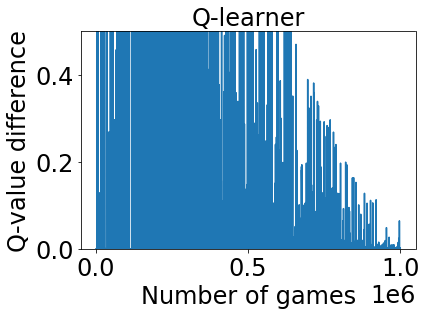

In [31]:
# modA = []
# for i in range(20000):
#     j = i*50 + np.random.randint(50)
#     modA.append(errorB_list[j])

# x_A = np.array(list(range(len(modA))))*50
# x_A = x_A.tolist()

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(x_A,modA)
plt.ylabel('Q-value difference',fontsize=24)
plt.xlabel('Number of games')
plt.title('Q-learner')
plt.savefig('Qlearner24.png',bbox_inches="tight")

### <span style="color:red"> Friend-Q Training</span>

In [32]:
class friend_Q:

    def epsilon_greedy_action(self,eps,QA,QB,s):
            x = np.random.random()
            if x < eps:
                actionA = np.random.randint(5)
                actionB = np.random.randint(5)
            else:
                actionA = Q_actions.index(Q_corr_actions[np.where(QA[s] == np.max(QA[s]))[0][0]][0])
                actionB = Q_actions.index(Q_corr_actions[np.where(QB[s] == np.max(QB[s]))[0][0]][1])
            return actionA, actionB
        
    def update_Q_tb(self,QA_tb,QB_tb,cur_state,action1,action2,alpha,reward1,
                    reward2,gamma,new_state,V1,V2):
        action = Q_corr_actions.index([action1,action2])
        if done == False:
            QA_tb[cur_state,action] = (1-alpha) * QA_tb[cur_state,action] + alpha * (reward1 + gamma * V1[new_state])
            QB_tb[cur_state,action] = (1-alpha) * QB_tb[cur_state,action] + alpha * (reward2 + gamma * V2[new_state])
        else:
            QA_tb[cur_state,action] = (1-alpha) * QA_tb[cur_state,action] + alpha * (reward1)
            QB_tb[cur_state,action] = (1-alpha) * QB_tb[cur_state,action] + alpha * (reward2)
        return QA_tb,QB_tb

In [33]:
t0 = time.localtime()
t0_clock = time.strftime("%H:%M:%S", t0)
print(t0_clock)
t0 = time.time()

Friend_Q = friend_Q()
QA_table = np.zeros([len(Q_states),len(Q_corr_actions)])
QB_table = np.zeros([len(Q_states),len(Q_corr_actions)])
VA = np.zeros(len(Q_states))
VB = np.zeros(len(Q_states))

start_eps = 1
start_alpha = 1
gamma = 0.99
alpha_decay = 0.999993
min_alpha = 0.001
epsilon_decay = 0.9999954
min_epsilon = 0.01

num_episodes = 1000000

chlg = soccer()
friend_errorA_list = []
friend_errorB_list = []
error_index = Q_corr_actions.index(['S','St'])
for i in range(num_episodes):
    if (i+1)%1000 == 0:
        print('The error in last 1000 games after {} games is {} & {}'.format(i+1,np.mean(friend_errorA_list[-1000:]),
                                                                           np.mean(friend_errorB_list[-1000:])))
    state = chlg.reset()
    nxt_state = state.copy()
    alpha = max(alpha_decay**i,min_alpha)
    epsilon = max(epsilon_decay**i,min_epsilon)
    done = False
    QA_old = QA_table.copy()
    QB_old = QB_table.copy()
    while done == False:
        Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        Q_state_ind = Q_states.index(Q_state)
        act_A_num, act_B_num = Friend_Q.epsilon_greedy_action(epsilon,QA_table,QB_table,Q_state_ind)
        act_A = Q_actions[act_A_num]
        act_B = Q_actions[act_B_num]
        nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
        Q_new_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        new_state = Q_states.index(Q_new_state)
        QA_table,QB_table = Friend_Q.update_Q_tb(QA_table,QB_table,Q_state_ind,act_A,act_B,alpha,rewardA,
                                       rewardB,gamma,new_state,VA,VB)
        if done == False:
            VA[Q_state_ind] = np.max(QA_table[Q_state_ind])
            VB[Q_state_ind] = np.max(QB_table[Q_state_ind])
    friend_errorA_list.append(np.abs(QA_table[71,error_index] - QA_old[71,error_index]))
    friend_errorB_list.append(np.abs(QB_table[71,error_index] - QB_old[71,error_index]))
    
    
t1 = time.localtime()
t1_clock = time.strftime("%H:%M:%S", t1)
print(t1_clock)
t1 = time.time()
print('The time required to run Friend_Q is {} hrs'.format((t1-t0)/3600))

col_list = []
for i in range(25):
    x = 'Col_' + str(i) 
    col_list.append(x)

16:30:19
The error in last 1000 games after 1000 games is 0.09909909907750288 & 0.09810810808659867
The error in last 1000 games after 2000 games is 2.1574621200670664e-11 & 2.148793498690793e-11
The error in last 1000 games after 3000 games is 0.0 & 0.0
The error in last 1000 games after 4000 games is 0.0 & 0.0
The error in last 1000 games after 5000 games is 0.0 & 0.0
The error in last 1000 games after 6000 games is 0.0 & 0.0
The error in last 1000 games after 7000 games is 0.0 & 0.0
The error in last 1000 games after 8000 games is 0.0 & 2.842170943040401e-17
The error in last 1000 games after 9000 games is 0.0 & 2.842170943040401e-17
The error in last 1000 games after 10000 games is 0.0 & 0.0
The error in last 1000 games after 11000 games is 0.0 & 2.842170943040401e-17
The error in last 1000 games after 12000 games is 0.0 & 0.0
The error in last 1000 games after 13000 games is 0.0 & 0.0
The error in last 1000 games after 14000 games is 0.0 & 0.0
The error in last 1000 games after 15

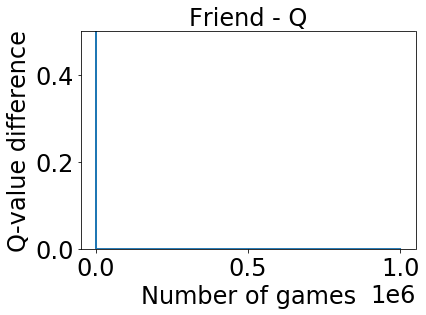

In [35]:
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(friend_errorA_list)
plt.ylabel('Q-value difference',fontsize=24)
plt.xlabel('Number of games')
plt.title('Friend - Q')
plt.savefig('FriendQ24.png',bbox_inches="tight")

### <span style="color:red"> Foe-Q traning</span>

In [18]:
class foe_q:
        
    def LPSolve(self,s,QA,QB,pA,pB):
    
        G = np.eye(6)[:-1,:]
        G = G*(-1)
        GA = np.append(G,np.hstack((np.reshape(QA[s],(5,5)).T,np.reshape(np.array([-1]*5),(5,-1))))*(-1), axis = 0)
        GB = np.append(G,np.hstack((np.reshape(QB[s],(5,5)),np.reshape(np.array([-1]*5),(5,-1))))*(-1), axis = 0)
    
        GA = GA.T
        GB = GB.T
        h = np.zeros(GA.shape[1]).tolist()
        c = np.zeros(GA.shape[0])
        c[-1] = -1
        c = c.tolist()
        A = np.ones((GA.shape[0],1))
        A[-1,-1] = 0
        A = A.tolist()
        GA = GA.tolist()
        GB = GB.tolist()
        b = [[1.]]
    
        GA = cvxopt.matrix(GA)
        GB = cvxopt.matrix(GB)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
    
        solutionA = cvxopt.solvers.lp(c, GA, h, A, b, solver='glpk')
        solutionB = cvxopt.solvers.lp(c, GB, h, A, b, solver='glpk')
        
        if solutionA['primal objective'] is None:
            valueA = 0
            pA = pA
        else:
            pA = list(solutionA['x'])
            valueA = pA.pop(-1)
            pA = [pi if pi >= 0 else 0 for pi in pA]
            sump = sum(pA)
            pA = [pi/sump for pi in pA]
            pA = np.array(pA)
        
        if solutionB['primal objective'] is None:
            valueB = 0
            pB = pB
        else:
            pB = list(solutionB['x'])
            valueB = pB.pop(-1)
            pB = [pi if pi >= 0 else 0 for pi in pB]
            sump = sum(pB)
            pB = [pi/sump for pi in pB]
            pB = np.array(pB)
        
        return valueA, valueB, pA, pB
        
    
    def epsilon_greedy_action(self, eps, policyA, policyB):
        x = np.random.random()
        if x < eps:
            actionA = np.random.randint(5)
            actionB = np.random.randint(5)
        else:
            y = np.random.random()
            if y < policyA[0]:
                actionA = 0
            elif y < policyA[0] + policyA[1]:
                actionA = 1
            elif y < policyA[0] + policyA[1] + policyA[2]:
                actionA = 2
            elif y < policyA[0] + policyA[1] + policyA[2] + policyA[3]:
                actionA = 3
            else:
                actionA = 4
                
            if y < policyB[0]:
                actionB = 0
            elif y < policyB[0] + policyB[1]:
                actionB = 1
            elif y < policyB[0] + policyB[1] + policyB[2]:
                actionB = 2
            elif y < policyB[0] + policyB[1] + policyB[2] + policyB[3]:
                actionB = 3
            else:
                actionB = 4
        return actionA, actionB
    
    def update_Q_tb(self,QA_tb,QB_tb,cur_state,action1,action2,alpha,reward1,reward2,gamma,new_state,V1,V2):
        action = Q_corr_actions.index([action1,action2])
        if done == False:
            QA_tb[cur_state,action] = (1-alpha) * QA_tb[cur_state,action] + alpha * (reward1 + gamma * V1[new_state])
            QB_tb[cur_state,action] = (1-alpha) * QB_tb[cur_state,action] + alpha * (reward2 + gamma * V2[new_state])
        else:
            QA_tb[cur_state,action] = (1-alpha) * QA_tb[cur_state,action] + alpha * (reward1)
            QB_tb[cur_state,action] = (1-alpha) * QB_tb[cur_state,action] + alpha * (reward2)
        return QA_tb,QB_tb

In [19]:
t0 = time.localtime()
t0_clock = time.strftime("%H:%M:%S", t0)
print(t0_clock)
t0 = time.time()


Foe_Q = foe_q()

QA_table = np.zeros([len(Q_states),len(Q_corr_actions)]) 
QB_table = np.zeros([len(Q_states),len(Q_corr_actions)])
VA = np.zeros(len(Q_states))
VB = np.zeros(len(Q_states))


start_eps = 1
start_alpha = 1
gamma = 0.99
alpha_decay = 0.999993
min_alpha = 0.001
epsilon_decay = 0.9999954
min_epsilon = 0.01

policyA = [0.2]*5
policyB = [0.2]*5
num_episodes = 1000000

chlg = soccer()
foe_errorA_list = []
foe_errorB_list = []
error_index = Q_corr_actions.index(['S','St'])
for i in range(num_episodes):
    if (i+1)%1000 == 0:
        print('The error in last 1000 games after {} games is {} & {}'.format(i+1,np.mean(foe_errorA_list[-1000:]),
                                                                           np.mean(foe_errorB_list[-1000:])))
    state = chlg.reset()
    nxt_state = state.copy()
    alpha = max(alpha_decay**i,min_alpha)
    epsilon = max(epsilon_decay**i,min_epsilon)
    done = False
    QA_old = QA_table.copy()
    QB_old = QB_table.copy()
    while done == False:
        Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        Q_state_ind = Q_states.index(Q_state)
        act_A_num,act_B_num = Foe_Q.epsilon_greedy_action(epsilon,policyA,policyB)
        act_A = Q_actions[act_A_num]
        act_B = Q_actions[act_B_num]
        nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
        Q_new_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        new_state = Q_states.index(Q_new_state)
        QA_table, QB_table = Foe_Q.update_Q_tb(QA_table,QB_table,Q_state_ind,act_A,act_B,alpha,rewardA,
                                               rewardB,gamma,new_state,VA,VB)
        valA,valB,policyA,policyB = Foe_Q.LPSolve(Q_state_ind,QA_table,QB_table,policyA,policyB)
        if done == False:
            VA[Q_state_ind] = valA
            VB[Q_state_ind] = valB
    
    foe_errorA_list.append(np.abs(QA_table[71,error_index] - QA_old[71,error_index]))
    foe_errorB_list.append(np.abs(QB_table[71,error_index] - QB_old[71,error_index]))
    
t1 = time.localtime()
t1_clock = time.strftime("%H:%M:%S", t1)
print(t1_clock)
t1 = time.time()
print('The time required to run Foe_Q is {} hrs'.format((t1-t0)/3600))

col_list = []
for i in range(25):
    x = 'Col_' + str(i) 
    col_list.append(x)
    
df = pd.DataFrame(QA_table, columns = col_list)
df.to_csv('your file location\Foe_Q_A.csv',index = False)
df = pd.DataFrame(QB_table, columns = col_list)
df.to_csv('your file location\Foe_Q_B.csv',index = False)

20:25:52
The error in last 1000 games after 1000 games is 0.0 & 0.0
The error in last 1000 games after 2000 games is 0.28754820487240806 & 0.2875482048724183
The error in last 1000 games after 3000 games is 0.04941134388829207 & 0.049411343888229285
The error in last 1000 games after 4000 games is 0.17202421726097156 & 0.17202421726334735
The error in last 1000 games after 5000 games is 0.03894083151519173 & 0.03894083151683541
The error in last 1000 games after 6000 games is 0.0 & 0.0
The error in last 1000 games after 7000 games is 0.006023098967886781 & 0.006023098968124771
The error in last 1000 games after 8000 games is 0.011504613281598623 & 0.011504613281341563
The error in last 1000 games after 9000 games is 0.009210190898281255 & 0.00921019089825822
The error in last 1000 games after 10000 games is 0.009667957689743375 & 0.009667957689719188
The error in last 1000 games after 11000 games is 0.01244795927349729 & 0.012447959273493993
The error in last 1000 games after 12000 gam

Text(0.5, 1.0, 'Foe-Q player B')

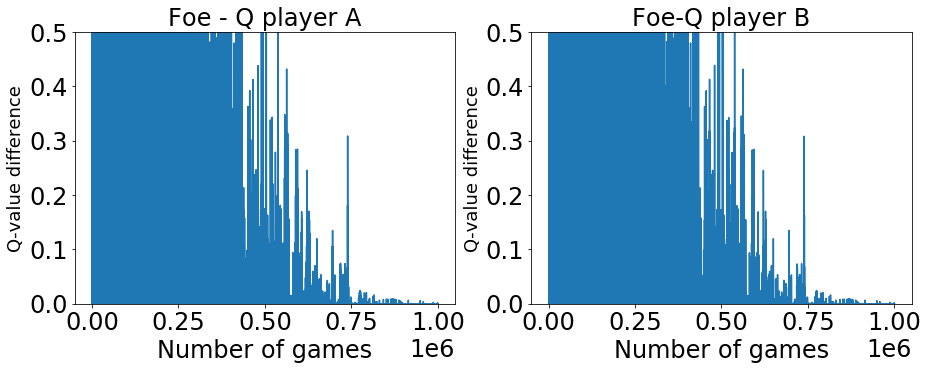

In [20]:
plt.subplots(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(foe_errorA_list)
plt.ylabel('Q-value difference',fontsize=18)
plt.xlabel('Number of games')
plt.title('Foe - Q player A')

plt.subplot(1, 2, 2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(foe_errorB_list)
plt.ylabel('Q-value difference',fontsize=18)
plt.xlabel('Number of games')
plt.title('Foe-Q player B')

### <span style="color:red"> uCEQ-Training</span>

In [31]:
class uceq:
    
    def LPSolve(self,s,Q_p,Q_o,policyA,policyB,eps_num,p):
        
        G = np.eye(25)*(-1)
        
        samples = 25
        data = list(range(25))
        chunks = [data[y:y+5] for y in range(0, 25, 5)]
        oc = np.transpose(np.array(chunks)).tolist()
        
        for i in range(5):
            new_chunks = chunks.copy()
            nc = oc.copy()
            target = new_chunks.pop(i)
            nt = nc.pop(i)
            
            for j in range(4):
                sum1 = []
                sum2 = []
                vals = np.zeros(25)
                valso = np.zeros(25)
                for k in range(5):
                    sum1.append(Q_p[s][target[k]] - Q_p[s][new_chunks[j][k]])
                    sum2.append(Q_o[s][nt[k]] - Q_o[s][nc[j][k]])
                sum1 = list(np.array(sum1)*(-1))
                sum2 = list(np.array(sum2)*(-1))
                vals[target] = sum1
                G = np.append(G,np.reshape(vals,(-1,25)), axis=0)
                valso[nt] = sum2
                G = np.append(G,np.reshape(valso,(-1,25)), axis=0)
                
        G = G.T
        h = np.zeros(G.shape[1])
        h = h.tolist()

        c = Q_p[s] + Q_o[s]
        c = c * -1
        c = c.tolist()
        c = [float(item) for item in c]
        
        A = np.ones((G.shape[0],1))
        A = A.tolist()
        G = G.tolist()
        
        b = [[1.]]
        
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        solution = cvxopt.solvers.lp(c, G, h, A, b, solver='glpk')
        
        if solution['primal objective'] is None:
            return 0,policyA,policyB,p
        
        else:
            p = list(solution['x'])

            p = [pi if pi >= 0 else 0 for pi in p]
            sump = sum(p)
            p = [pi/sump for pi in p]

            p = np.array(p)
            polA = np.reshape(p, (-1, 5)).sum(axis=-1)
            polB = np.reshape(p, (-1, 5)).T.sum(axis=-1)
        
            return solution['primal objective'],polA,polB,p
        
    
    def epsilon_greedy_action(self, eps, policyA, policyB):
        x = np.random.random()
        if x < eps:
            actionA = np.random.randint(5)
            actionB = np.random.randint(5)
        else:
            y = np.random.random()
            if y < policyA[0]:
                actionA = 0
            elif y < policyA[0] + policyA[1]:
                actionA = 1
            elif y < policyA[0] + policyA[1] + policyA[2]:
                actionA = 2
            elif y < policyA[0] + policyA[1] + policyA[2] + policyA[3]:
                actionA = 3
            else:
                actionA = 4
                
            if y < policyB[0]:
                actionB = 0
            elif y < policyB[0] + policyB[1]:
                actionB = 1
            elif y < policyB[0] + policyB[1] + policyB[2]:
                actionB = 2
            elif y < policyB[0] + policyB[1] + policyB[2] + policyB[3]:
                actionB = 3
            else:
                actionB = 4
        return actionA, actionB
    
    
    def update_Q_tb(self,Q_tb1,Q_tb2,cur_state,action1,action2,alpha,reward1,reward2,gamma,new_state,V1,V2):
        action = Q_corr_actions.index([action1,action2])
        if done == False:
            Q_tb1[cur_state,action] = (1-alpha) * Q_tb1[cur_state,action] + alpha * (reward1 + gamma * V1[new_state])
            Q_tb2[cur_state,action] = (1-alpha) * Q_tb2[cur_state,action] + alpha * (reward2 + gamma * V2[new_state])
        else:
            Q_tb1[cur_state,action] = (1-alpha) * Q_tb1[cur_state,action] + alpha * (reward1)
            Q_tb2[cur_state,action] = (1-alpha) * Q_tb2[cur_state,action] + alpha * (reward2)
        return Q_tb1,Q_tb2

In [32]:
t0 = time.localtime()
t0_clock = time.strftime("%H:%M:%S", t0)
print(t0_clock)
t0 = time.time()

Uceq = uceq()
Q_table_play = np.zeros([len(Q_states),len(Q_corr_actions)])
Q_table_oppo = np.zeros([len(Q_states),len(Q_corr_actions)])
Vs_play = np.zeros(len(Q_states))
Vs_oppo = np.zeros(len(Q_states))

start_eps = 1
start_alpha = 1
gamma = 0.99
alpha_decay = 0.999993
min_alpha = 0.001
epsilon_decay = 0.9999954
min_epsilon = 0.01

policyA = [0.2]*5
policyB = [0.2]*5
p = [0.04]*25

num_episodes = 1000000

chlg = soccer()
uceq_errorA_list = []
uceq_errorB_list = []

error_index = Q_corr_actions.index(['S','St'])


for i in range(num_episodes):
    if (i+1)%1000 == 0:
        print('The error in last 1000 games after {} games is {} & {}'.format(i+1,np.mean(uceq_errorA_list[-1000:]),
                                                                           np.mean(uceq_errorB_list[-1000:])))
    eps_num = i
    state = chlg.reset()
    nxt_state = state.copy()
    alpha = max(alpha_decay**i,min_alpha)
    epsilon = max(epsilon_decay**i,min_epsilon)
    done = False
    QA_old = Q_table_play.copy()
    QB_old = Q_table_oppo.copy()
    eps_num = i
    steps = 0
    while done == False:
        Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        Q_state_ind = Q_states.index(Q_state)
        act_A_num,act_B_num  = Uceq.epsilon_greedy_action(epsilon,policyA,policyB)
        act_A = Q_actions[act_A_num]
        act_B = Q_actions[act_B_num]
        nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
        steps += 1
        if steps == 100:
            break
        Q_new_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        new_state = Q_states.index(Q_new_state)
        Q_table_play,Q_table_oppo = Uceq.update_Q_tb(Q_table_play,Q_table_oppo,Q_state_ind,act_A,act_B,alpha,rewardA,rewardB,gamma,new_state,Vs_play,Vs_oppo)
        val,policyA,policyB,p = Uceq.LPSolve(Q_state_ind,Q_table_play,Q_table_oppo,policyA,policyB,eps_num,p)
    
        if done == False:
            Vs_oppo[Q_state_ind] = np.sum(p * Q_table_oppo[Q_state_ind])
            Vs_play[Q_state_ind] = np.sum(p * Q_table_play[Q_state_ind])

    
    uceq_errorA_list.append(np.abs(Q_table_play[71,error_index] - QA_old[71,error_index]))
    uceq_errorB_list.append(np.abs(Q_table_oppo[71,error_index] - QB_old[71,error_index]))

t1 = time.localtime()
t1_clock = time.strftime("%H:%M:%S", t1)
print(t1_clock)
t1 = time.time()
print('The time required to run UCE_Q is {} hrs'.format((t1-t0)/3600))

col_list = []
for i in range(25):
    x = 'Col_' + str(i) 
    col_list.append(x)
    


21:36:45
The error in last 1000 games after 1000 games is 0.0 & 0.0
The error in last 1000 games after 2000 games is 0.09800981499782627 & 0.09800981499782627
The error in last 1000 games after 3000 games is 0.07832013365993486 & 0.07832013365993486
The error in last 1000 games after 4000 games is 0.05430709086036562 & 0.05430709086036562
The error in last 1000 games after 5000 games is 0.052747178711987044 & 0.052747178711987044
The error in last 1000 games after 6000 games is 0.017096858565554613 & 0.017096858565554613
The error in last 1000 games after 7000 games is 0.0026345790996326174 & 0.0026345790996326174
The error in last 1000 games after 8000 games is 0.023559778725409757 & 0.023559778725409757
The error in last 1000 games after 9000 games is 0.0059649755203030706 & 0.0059649755203030706
The error in last 1000 games after 10000 games is 0.01495706078781656 & 0.01495706078781656
The error in last 1000 games after 11000 games is 0.03696618980157028 & 0.03696618980157028
The er

In [34]:
df = pd.DataFrame(Q_table_play, columns = col_list)
df.to_csv('your file location\uceq_playA_Q2.csv',index = False)

df = pd.DataFrame(Q_table_oppo, columns = col_list)
df.to_csv('your file location\uceq_playB_Q2.csv',index = False)

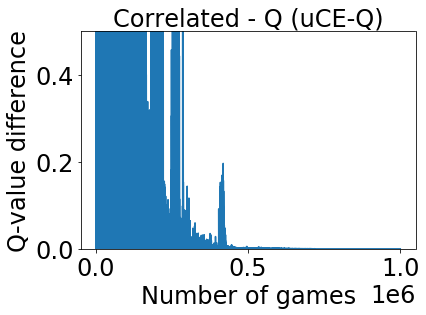

In [25]:
params = {'legend.fontsize':24,
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
pylab.rcParams.update(params)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(uceq_errorA_list)
plt.ylabel('Q-value difference',fontsize=24)
plt.xlabel('Number of games')
plt.title('Correlated - Q (uCE-Q)')
plt.savefig('UCE-Q24.png',bbox_inches="tight")

### <span style="color:red"> e-CEQ Training</span>

In [16]:
class eceq:
    
    def LPSolve(self,s,Q_p,Q_o,policyA,policyB,eps_num,p):
        
        G = np.eye(26)[:-1,:]
        G = G*(-1)
        
        samples = 25
        data = list(range(25))
        chunks = [data[y:y+5] for y in range(0, 25, 5)]
        oc = np.transpose(np.array(chunks)).tolist()
        
        for i in range(5):
            new_chunks = chunks.copy()
            nc = oc.copy()
            target = new_chunks.pop(i)
            nt = nc.pop(i)
            
            for j in range(4):
                sum1 = []
                sum2 = []
                vals = np.zeros(25)
                valso = np.zeros(25)
                for k in range(5):
                    sum1.append(Q_p[s][target[k]] - Q_p[s][new_chunks[j][k]])
                    sum2.append(Q_o[s][nt[k]] - Q_o[s][nc[j][k]])
                sum1 = list(np.array(sum1)*(-1))
                sum2 = list(np.array(sum2)*(-1))
                vals[target] = sum1
                vals = np.append(vals,[0])
                G = np.append(G,np.reshape(vals,(-1,26)), axis=0)
                valso[nt] = sum2
                valso = np.append(valso,[0])
                G = np.append(G,np.reshape(valso,(-1,26)), axis=0)
        G = np.append(G,np.reshape(np.append(Q_p[s]*(-1),[1]),(-1,26)),axis = 0)
        G = np.append(G,np.reshape(np.append(Q_o[s]*(-1),[1]),(-1,26)),axis = 0)      
        
        G = G.T
        h = np.zeros(G.shape[1])
        h = h.tolist()

        c = np.zeros(G.shape[0])
        c[-1] = -1
        c = c.tolist()
        c = [float(item) for item in c]
        
        A = np.ones((G.shape[0],1))
        A[-1,-1] = 0
        A = A.tolist()
        G = G.tolist()
        
        b = [[1.]]
        
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        solution = cvxopt.solvers.lp(c, G, h, A, b, solver='glpk')
        
        if solution['primal objective'] is None:
            return 0,policyA,policyB,p
        
        else:
            p = list(solution['x'])
            value = p.pop(-1)

            p = [pi if pi >= 0 else 0 for pi in p]
            sump = sum(p)
            p = [pi/sump for pi in p]

            p = np.array(p)
            polA = np.reshape(p, (-1, 5)).sum(axis=-1)
            polB = np.reshape(p, (-1, 5)).T.sum(axis=-1)
        
        return solution['primal objective'],polA,polB,p
        
    
    def epsilon_greedy_action(self, eps, policyA, policyB):
        x = np.random.random()
        if x < eps:
            actionA = np.random.randint(5)
            actionB = np.random.randint(5)
        else:
            y = np.random.random()
            if y < policyA[0]:
                actionA = 0
            elif y < policyA[0] + policyA[1]:
                actionA = 1
            elif y < policyA[0] + policyA[1] + policyA[2]:
                actionA = 2
            elif y < policyA[0] + policyA[1] + policyA[2] + policyA[3]:
                actionA = 3
            else:
                actionA = 4
                
            if y < policyB[0]:
                actionB = 0
            elif y < policyB[0] + policyB[1]:
                actionB = 1
            elif y < policyB[0] + policyB[1] + policyB[2]:
                actionB = 2
            elif y < policyB[0] + policyB[1] + policyB[2] + policyB[3]:
                actionB = 3
            else:
                actionB = 4
        return actionA, actionB
    
    
    def update_Q_tb(self,Q_tb1,Q_tb2,cur_state,action1,action2,alpha,reward1,reward2,gamma,new_state,V1,V2):
        action = Q_corr_actions.index([action1,action2])
        if done == False:
            Q_tb1[cur_state,action] = (1-alpha) * Q_tb1[cur_state,action] + alpha * (reward1 + gamma * V1[new_state])
            Q_tb2[cur_state,action] = (1-alpha) * Q_tb2[cur_state,action] + alpha * (reward2 + gamma * V2[new_state])
        else:
            Q_tb1[cur_state,action] = (1-alpha) * Q_tb1[cur_state,action] + alpha * (reward1)
            Q_tb2[cur_state,action] = (1-alpha) * Q_tb2[cur_state,action] + alpha * (reward2)
        return Q_tb1,Q_tb2

In [17]:
t0 = time.localtime()
t0_clock = time.strftime("%H:%M:%S", t0)
print(t0_clock)
t0 = time.time()

Eceq = eceq()
Q_table_play = np.zeros([len(Q_states),len(Q_corr_actions)])
Q_table_oppo = np.zeros([len(Q_states),len(Q_corr_actions)])
Vs_play = np.zeros(len(Q_states))
Vs_oppo = np.zeros(len(Q_states))

start_eps = 1
start_alpha = 1
gamma = 0.99
alpha_decay = 0.999993
min_alpha = 0.001
epsilon_decay = 0.9999954
min_epsilon = 0.01

policyA = [0.2]*5
policyB = [0.2]*5
p = [0.04]*25

num_episodes = 1000000

chlg = soccer()
eceq_errorA_list = []
eceq_errorB_list = []

error_index = Q_corr_actions.index(['S','St'])


for i in range(num_episodes):
    if (i+1)%1000 == 0:
        print('The error in last 1000 games after {} games is {} & {}'.format(i+1,np.mean(eceq_errorA_list[-1000:]),
                                                                           np.mean(eceq_errorB_list[-1000:])))
    eps_num = i
    state = chlg.reset()
    nxt_state = state.copy()
    alpha = max(alpha_decay**i,min_alpha)
    epsilon = max(epsilon_decay**i,min_epsilon)
    done = False
    QA_old = Q_table_play.copy()
    QB_old = Q_table_oppo.copy()
    eps_num = i
    steps = 0
    while done == False:
        Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        Q_state_ind = Q_states.index(Q_state)
        act_A_num,act_B_num  = Eceq.epsilon_greedy_action(epsilon,policyA,policyB)
        act_A = Q_actions[act_A_num]
        act_B = Q_actions[act_B_num]
        nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
        steps += 1
        if steps == 100:
            break
        Q_new_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        new_state = Q_states.index(Q_new_state)
        Q_table_play,Q_table_oppo = Eceq.update_Q_tb(Q_table_play,Q_table_oppo,Q_state_ind,act_A,act_B,alpha,rewardA,rewardB,gamma,new_state,Vs_play,Vs_oppo)
        val,policyA,policyB,p = Eceq.LPSolve(Q_state_ind,Q_table_play,Q_table_oppo,policyA,policyB,eps_num,p)
    
        if done == False:
            Vs_oppo[Q_state_ind] = np.sum(p * Q_table_oppo[Q_state_ind])
            Vs_play[Q_state_ind] = np.sum(p * Q_table_play[Q_state_ind])

    
    eceq_errorA_list.append(np.abs(Q_table_play[71,error_index] - QA_old[71,error_index]))
    eceq_errorB_list.append(np.abs(Q_table_oppo[71,error_index] - QB_old[71,error_index]))

t1 = time.localtime()
t1_clock = time.strftime("%H:%M:%S", t1)
print(t1_clock)
t1 = time.time()
print('The time required to run ECE_Q is {} hrs'.format((t1-t0)/3600))

col_list = []
for i in range(25):
    x = 'Col_' + str(i) 
    col_list.append(x)
    
df = pd.DataFrame(Q_table_play, columns = col_list)
df.to_csv('your file location\eceq_playA_Q.csv',index = False)

df = pd.DataFrame(Q_table_oppo, columns = col_list)
df.to_csv('your file location\eceq_playB_Q.csv',index = False)


Text(0.5, 1.0, 'Correlated - Q (eCE-Q)')

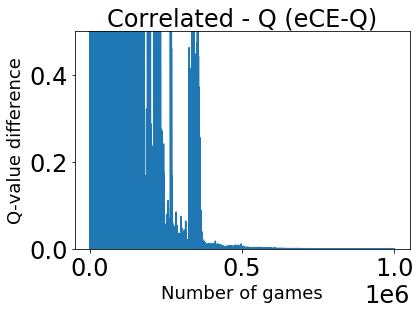

In [18]:
eceq_errorA_list = pd.read_csv('your file location\ECEQ_A_error.csv')
eceq_errorA_list = eceq_errorA_list.to_numpy()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(eceq_errorA_list)
plt.ylabel('Q-value difference',fontsize=18)
plt.xlabel('Number of games',fontsize=18)
plt.title('Correlated - Q (eCE-Q)')
# plt.savefig('ECEQA.png',bbox_inches="tight")

### <span style="color:red"> r-CEQ Training</span>

In [19]:
class rceq:
    
    def LPSolve(self,s,Q_p,Q_o,policyA,policyB,eps_num,p):
        
        G = np.eye(26)[:-1,:]
        G = G*(-1)
        
        samples = 25
        data = list(range(25))
        chunks = [data[y:y+5] for y in range(0, 25, 5)]
        oc = np.transpose(np.array(chunks)).tolist()
        
        for i in range(5):
            new_chunks = chunks.copy()
            nc = oc.copy()
            target = new_chunks.pop(i)
            nt = nc.pop(i)
            
            for j in range(4):
                sum1 = []
                sum2 = []
                vals = np.zeros(25)
                valso = np.zeros(25)
                for k in range(5):
                    sum1.append(Q_p[s][target[k]] - Q_p[s][new_chunks[j][k]])
                    sum2.append(Q_o[s][nt[k]] - Q_o[s][nc[j][k]])
                sum1 = list(np.array(sum1)*(-1))
                sum2 = list(np.array(sum2)*(-1))
                vals[target] = sum1
                vals = np.append(vals,[0])
                G = np.append(G,np.reshape(vals,(-1,26)), axis=0)
                valso[nt] = sum2
                valso = np.append(valso,[0])
                G = np.append(G,np.reshape(valso,(-1,26)), axis=0)
        G = np.append(G,np.reshape(np.append(Q_p[s],[-1]),(-1,26)),axis = 0)
        G = np.append(G,np.reshape(np.append(Q_o[s],[-1]),(-1,26)),axis = 0)
        g = np.zeros(26)
        g[-1] = 1
        G = np.append(G,np.reshape(g,(-1,26)),axis = 0)
        
        G = G.T
        h = np.zeros(G.shape[1])
        h[-1] = 100
        h = h.tolist()

        c = np.zeros(G.shape[0])
        c[-1] = -1
        c = c.tolist()
        c = [float(item) for item in c]
        
        A = np.ones((G.shape[0],1))
        A[-1,-1] = 0
        A = A.tolist()
        G = G.tolist()
    
        
        b = [[1.]]
        
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        solution = cvxopt.solvers.lp(c, G, h, A, b, solver='glpk')
        
        if solution['primal objective'] is None:
            return 0,policyA,policyB,p
        
        else:
            p = list(solution['x'])
            value = p.pop(-1)

            p = [pi if pi >= 0 else 0 for pi in p]
            sump = sum(p)
            p = [pi/sump for pi in p]

            p = np.array(p)
            polA = np.reshape(p, (-1, 5)).sum(axis=-1)
            polB = np.reshape(p, (-1, 5)).T.sum(axis=-1)
        
        return value,polA,polB,p
        
    
    def epsilon_greedy_action(self, eps, policyA, policyB):
        x = np.random.random()
        if x < eps:
            actionA = np.random.randint(5)
            actionB = np.random.randint(5)
        else:
            y = np.random.random()
            if y < policyA[0]:
                actionA = 0
            elif y < policyA[0] + policyA[1]:
                actionA = 1
            elif y < policyA[0] + policyA[1] + policyA[2]:
                actionA = 2
            elif y < policyA[0] + policyA[1] + policyA[2] + policyA[3]:
                actionA = 3
            else:
                actionA = 4
                
            if y < policyB[0]:
                actionB = 0
            elif y < policyB[0] + policyB[1]:
                actionB = 1
            elif y < policyB[0] + policyB[1] + policyB[2]:
                actionB = 2
            elif y < policyB[0] + policyB[1] + policyB[2] + policyB[3]:
                actionB = 3
            else:
                actionB = 4
        return actionA, actionB
    
    
    def update_Q_tb(self,Q_tb1,Q_tb2,cur_state,action1,action2,alpha,reward1,reward2,gamma,new_state,V1,V2):
        action = Q_corr_actions.index([action1,action2])
        if done == False:
            Q_tb1[cur_state,action] = (1-alpha) * Q_tb1[cur_state,action] + alpha * (reward1 + gamma * V1[new_state])
            Q_tb2[cur_state,action] = (1-alpha) * Q_tb2[cur_state,action] + alpha * (reward2 + gamma * V2[new_state])
        else:
            Q_tb1[cur_state,action] = (1-alpha) * Q_tb1[cur_state,action] + alpha * (reward1)
            Q_tb2[cur_state,action] = (1-alpha) * Q_tb2[cur_state,action] + alpha * (reward2)
        return Q_tb1,Q_tb2

In [20]:
t0 = time.localtime()
t0_clock = time.strftime("%H:%M:%S", t0)
print(t0_clock)
t0 = time.time()

Rceq = rceq()
Q_table_play = np.zeros([len(Q_states),len(Q_corr_actions)])
Q_table_oppo = np.zeros([len(Q_states),len(Q_corr_actions)])
Vs_play = np.zeros(len(Q_states))
Vs_oppo = np.zeros(len(Q_states))

start_eps = 1
start_alpha = 1
gamma = 0.99
alpha_decay = 0.999993
min_alpha = 0.001
epsilon_decay = 0.9999954
min_epsilon = 0.01

policyA = [0.2]*5
policyB = [0.2]*5
p = [0.04]*25

num_episodes = 1000000

chlg = soccer()
rceq_errorA_list = []
rceq_errorB_list = []

error_index = Q_corr_actions.index(['S','St'])


for i in range(num_episodes):
    if (i+1)%1000 == 0:
        print('The error in last 1000 games after {} games is {} & {}'.format(i+1,np.mean(rceq_errorA_list[-1000:]),
                                                                           np.mean(rceq_errorB_list[-1000:])))
    eps_num = i
    state = chlg.reset()
    nxt_state = state.copy()
    alpha = max(alpha_decay**i,min_alpha)
    epsilon = max(epsilon_decay**i,min_epsilon)
    done = False
    QA_old = Q_table_play.copy()
    QB_old = Q_table_oppo.copy()
    eps_num = i
    steps = 0
    while done == False:
        Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        Q_state_ind = Q_states.index(Q_state)
        act_A_num,act_B_num  = Rceq.epsilon_greedy_action(epsilon,policyA,policyB)
        act_A = Q_actions[act_A_num]
        act_B = Q_actions[act_B_num]
        nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
        steps += 1
        if steps == 100:
            break
        Q_new_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
        new_state = Q_states.index(Q_new_state)
        Q_table_play,Q_table_oppo = Rceq.update_Q_tb(Q_table_play,Q_table_oppo,Q_state_ind,act_A,act_B,alpha,rewardA,rewardB,gamma,new_state,Vs_play,Vs_oppo)
        val,policyA,policyB,p = Rceq.LPSolve(Q_state_ind,Q_table_play,Q_table_oppo,policyA,policyB,eps_num,p)
    
        if done == False:
            Vs_oppo[Q_state_ind] = np.sum(p * Q_table_oppo[Q_state_ind])
            Vs_play[Q_state_ind] = np.sum(p * Q_table_play[Q_state_ind])

    
    rceq_errorA_list.append(np.abs(Q_table_play[71,error_index] - QA_old[71,error_index]))
    rceq_errorB_list.append(np.abs(Q_table_oppo[71,error_index] - QB_old[71,error_index]))

t1 = time.localtime()
t1_clock = time.strftime("%H:%M:%S", t1)
print(t1_clock)
t1 = time.time()
print('The time required to run ECE_Q is {} hrs'.format((t1-t0)/3600))

col_list = []
for i in range(25):
    x = 'Col_' + str(i) 
    col_list.append(x)
    
df = pd.DataFrame(Q_table_play, columns = col_list)
df.to_csv('your file location\rceq_playA_Q.csv',index = False)

df = pd.DataFrame(Q_table_oppo, columns = col_list)
df.to_csv('your file location\rceq_playB_Q.csv',index = False)


Text(0.5, 1.0, 'Correlated - Q (rCE-Q)')

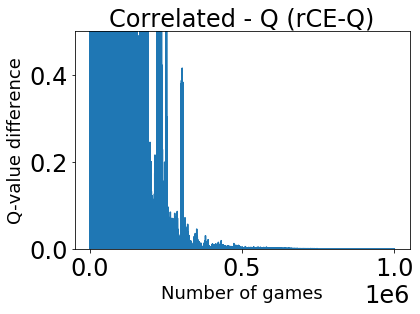

In [22]:
rceq_errorA_list = pd.read_csv('your file location\rceq_A_error.csv')
rceq_errorA_list = rceq_errorA_list.to_numpy()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0, 0.5)
plt.plot(rceq_errorA_list)
plt.ylabel('Q-value difference',fontsize=18)
plt.xlabel('Number of games',fontsize=18)
plt.title('Correlated - Q (rCE-Q)')
# plt.savefig('RCEQA.png',bbox_inches="tight")

## <span style="color:red"> Evaluation of Trained Agent</span>

### <span style="color:red"> Evaluating Q-leaner</span>

In [4]:
class Qlearning_eval:
    
    def __init__(self,player):
        self.player = player
    
    def policy(self):
        df = pd.read_csv('your file location\Basic_Q_A.csv')
        QA_df = df.to_numpy()
        policyA = np.argmax(QA_df,axis = 1)
        df = pd.read_csv('your file location\Basic_Q_B.csv')
        QB_df = df.to_numpy()
        policyB = np.argmax(QB_df,axis = 1)
        if self.player == 'A':
            return policyA
        else:
            return policyB
        
    def action (self,state,policy):
        action = Q_actions[policy[state]]
        return action

In [5]:
A = Qlearning_eval('A')
B = Qlearning_eval('B')
polA = A.policy()
polB = B.policy()

s = 71

print('The policy of A in state s is to take determinsitic action of ' + Q_actions[polA[s]])
print('The policy of B in state s is to take determinsitic action of ' + Q_actions[polB[s]])

The policy of A in state s is to take determinsitic action of St
The policy of B in state s is to take determinsitic action of S


### <span style="color:red"> Evaluating Friend-Q </span>

In [6]:
class Friend_eval:
    def __init__(self,player):
        self.player = player
      
    def policy(self):
        df = pd.read_csv('your file location\Friend_Q_A.csv')
        QA_df = df.to_numpy()
        policyA = np.argmax(QA_df,axis = 1)
        df = pd.read_csv('your file location\Friend_Q_B.csv')
        QB_df = df.to_numpy()
        policyB = np.argmax(QB_df,axis = 1)
        if self.player == 'A':
            return policyA
        else:
            return policyB
        
    def action (self,state,policy):
        if self.player == 'A':
            action = Q_corr_actions[policy[state]][0]
        elif self.player == 'B':
            action = Q_corr_actions[policy[state]][1]
        return action

In [7]:
A = Friend_eval('A')
B = Friend_eval('B')
polA = A.policy()
polB = B.policy()

s = 71

print('The policy of A in state s is to take determinsitic action of ' + Q_corr_actions[polA[s]][0])
print('The policy of B in state s is to take determinsitic action of ' + Q_corr_actions[polB[s]][1])

The policy of A in state s is to take determinsitic action of E
The policy of B in state s is to take determinsitic action of E


### <span style="color:red"> Evaluating Foe-Q</span>

In [8]:
class Foe_eval:
    def __init__(self,player):
        self.player = player
        
    def policy(self):
        df = pd.read_csv('your file location\Foe_Q_A.csv')
        QA_df = df.to_numpy()
        df = pd.read_csv('your file location\Foe_B_Q.csv')
        QB_df = df.to_numpy()
#         QB_df = QA_df *(-1)
        G = np.eye(6)[:-1,:]
        G = G*(-1)
        h = np.zeros(10).tolist()
        c = np.zeros(6)
        c[-1] = -1
        c = c.tolist()
        A = np.ones((6,1))
        A[-1,-1] = 0
        A = A.tolist()
        b = [[1.]]
        policyA = []
        policyB = []
        
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        for i in range(len(df)):
            if self.player == 'A':
                GA = np.append(G,np.hstack((np.reshape(QA_df[i],(5,5)).T,np.reshape(np.array([-1]*5),(5,-1))))*(-1), axis = 0)
                GA = GA.T
                GA = GA.tolist()
                GA = cvxopt.matrix(GA)
                solution = cvxopt.solvers.lp(c, GA, h, A, b, solver='glpk')
                p = list(solution['x'])
                value = p.pop(-1)
                p = [pi if pi >= 0 else 0 for pi in p]
                sump = sum(p)
                p = [pi/sump for pi in p]
                policyA.append(p)
                
            elif self.player == 'B':
                GB = np.append(G,np.hstack((np.reshape(QB_df[i],(5,5)),np.reshape(np.array([-1]*5),(5,-1))))*(-1), axis = 0)
                GB = GB.T
                GB = GB.tolist()
                GB = cvxopt.matrix(GB)
                solution = cvxopt.solvers.lp(c, GB, h, A, b, solver='glpk')
                p = list(solution['x'])
                value = p.pop(-1)
                p = [pi if pi >= 0 else 0 for pi in p]
                sump = sum(p)
                p = [pi/sump for pi in p]
                p = np.array(p)
                policyB.append(p)
                
        if self.player == 'A':
            return policyA
        elif self.player == 'B':
            return policyB
        
    def action(self, state, policy):
        y = np.random.random()
        
        pol = policy[state]
        
        if y < pol[0]:
            action = 0
        elif y < pol[0] + pol[1]:                
            action = 1
        elif y < pol[0] + pol[1] + pol[2]:
            action = 2
        elif y < pol[0] + pol[1] + pol[2] + pol[3]:
            action = 3
        else:
            action = 4
        return Q_actions[action]
    

In [9]:
A = Foe_eval('A')
B = Foe_eval('B')
polA = A.policy()
polB = B.policy()

s = 71

policyA = [round(p,2) for p in polA[71]]
policyB = [round(p,2) for p in polB[71]]

print('The policy of A in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyA,
                                                                                                                    Q_actions))
print()

print('The policy of B in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyB,
                                                                                                                    Q_actions))

The policy of A in state s is to take probabilistic actions with probabilities of [0.51, 0.0, 0.0, 0.49, 0.0] for ['N', 'E', 'W', 'S', 'St'] actions 

The policy of B in state s is to take probabilistic actions with probabilities of [0.0, 0.0, 0.0, 0.47, 0.53] for ['N', 'E', 'W', 'S', 'St'] actions 


### <span style="color:red"> Evaluating uCE-Q </span>

In [10]:
class Uceq_eval:
    
    def __init__(self,player):
        self.player = player
    
    def LPSolve(self,s,Q_p,Q_o):
        
        G = np.eye(25)*(-1)
        
        samples = 25
        data = list(range(25))
        chunks = [data[y:y+5] for y in range(0, 25, 5)]
        oc = np.transpose(np.array(chunks)).tolist()
        
        for i in range(5):
            new_chunks = chunks.copy()
            nc = oc.copy()
            target = new_chunks.pop(i)
            nt = nc.pop(i)
            
            for j in range(4):
                sum1 = []
                sum2 = []
                vals = np.zeros(25)
                valso = np.zeros(25)
                for k in range(5):
                    sum1.append(Q_p[s][target[k]] - Q_p[s][new_chunks[j][k]])
                    sum2.append(Q_o[s][nt[k]] - Q_o[s][nc[j][k]])
                sum1 = list(np.array(sum1)*(-1))
                sum2 = list(np.array(sum2)*(-1))
                vals[target] = sum1
                G = np.append(G,np.reshape(vals,(-1,25)), axis=0)
                valso[nt] = sum2
                G = np.append(G,np.reshape(valso,(-1,25)), axis=0)
                
        G = G.T
        h = np.zeros(G.shape[1])
        h = h.tolist()

        c = Q_p[s] + Q_o[s]
        c = c * -1
        c = c.tolist()
        c = [float(item) for item in c]
        
        A = np.ones((G.shape[0],1))
        A = A.tolist()
        G = G.tolist()
        
        b = [[1.]]
        
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        solution = cvxopt.solvers.lp(c, G, h, A, b, solver='glpk')
        

        p = list(solution['x'])

        p = [pi if pi >= 0 else 0 for pi in p]
        sump = sum(p)
        p = [pi/sump for pi in p]

        p = np.array(p)
        polA = np.reshape(p, (-1, 5)).sum(axis=-1)
        polB = np.reshape(p, (-1, 5)).T.sum(axis=-1)
        
        return polA,polB
    
    
    def policy(self):
        policyA = []
        policyB = []
        
        df = pd.read_csv('your file location\uceq_playA_Q1.csv')
        Q_p = df.to_numpy()
        df = pd.read_csv('your file location\uceq_playB_Q1.csv')
        Q_o = df.to_numpy()
        
        for i in range(len(Q_p)):
            polA,polB = self.LPSolve(i,Q_p,Q_o)
            policyA.append(polA)
            policyB.append(polB)
            
        if self.player == 'A':
            return policyA
        elif self.player == 'B':
            return policyB
        
    def action(self, state, policy):
        y = np.random.random()
        
        pol = policy[state]
        
        if y < pol[0]:
            action = 0
        elif y < pol[0] + pol[1]:                
            action = 1
        elif y < pol[0] + pol[1] + pol[2]:
            action = 2
        elif y < pol[0] + pol[1] + pol[2] + pol[3]:
            action = 3
        else:
            action = 4
        return Q_actions[action]

In [11]:
A = Uceq_eval('A')
B = Uceq_eval('B')
polA = A.policy()
polB = B.policy()

s = 71

policyA = [round(p,2) for p in polA[71]]
policyB = [round(p,2) for p in polB[71]]

print('The policy of A in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyA,
                                                                                                                    Q_actions))
print()

print('The policy of B in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyB,
                                                                                                                    Q_actions))

The policy of A in state s is to take probabilistic actions with probabilities of [0.24, 0.0, 0.0, 0.54, 0.22] for ['N', 'E', 'W', 'S', 'St'] actions 

The policy of B in state s is to take probabilistic actions with probabilities of [0.27, 0.0, 0.0, 0.45, 0.28] for ['N', 'E', 'W', 'S', 'St'] actions 


### <span style="color:red"> Evaluating eCE-Q</span>

In [12]:
class Eceq_eval:
    
    def __init__(self,player):
        self.player = player
    
    def LPSolve(self,s,Q_p,Q_o):
        
        G = np.eye(26)[:-1,:]
        G = G*(-1)
        
        samples = 25
        data = list(range(25))
        chunks = [data[y:y+5] for y in range(0, 25, 5)]
        oc = np.transpose(np.array(chunks)).tolist()
        
        for i in range(5):
            new_chunks = chunks.copy()
            nc = oc.copy()
            target = new_chunks.pop(i)
            nt = nc.pop(i)
            
            for j in range(4):
                sum1 = []
                sum2 = []
                vals = np.zeros(25)
                valso = np.zeros(25)
                for k in range(5):
                    sum1.append(Q_p[s][target[k]] - Q_p[s][new_chunks[j][k]])
                    sum2.append(Q_o[s][nt[k]] - Q_o[s][nc[j][k]])
                sum1 = list(np.array(sum1)*(-1))
                sum2 = list(np.array(sum2)*(-1))
                vals[target] = sum1
                vals = np.append(vals,[0])
                G = np.append(G,np.reshape(vals,(-1,26)), axis=0)
                valso[nt] = sum2
                valso = np.append(valso,[0])
                G = np.append(G,np.reshape(valso,(-1,26)), axis=0)
        G = np.append(G,np.reshape(np.append(Q_p[s]*(-1),[1]),(-1,26)),axis = 0)
        G = np.append(G,np.reshape(np.append(Q_o[s]*(-1),[1]),(-1,26)),axis = 0)      
        
        G = G.T
        h = np.zeros(G.shape[1])
        h = h.tolist()

        c = np.zeros(G.shape[0])
        c[-1] = -1
        c = c.tolist()
        c = [float(item) for item in c]
        
        A = np.ones((G.shape[0],1))
        A[-1,-1] = 0
        A = A.tolist()
        G = G.tolist()
        
        b = [[1.]]
        
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        solution = cvxopt.solvers.lp(c, G, h, A, b, solver='glpk')
        
        p = list(solution['x'])
        value = p.pop(-1)
        p = [pi if pi >= 0 else 0 for pi in p]
        sump = sum(p)
        p = [pi/sump for pi in p]
        p = np.array(p)
        polA = np.reshape(p, (-1, 5)).sum(axis=-1)
        polB = np.reshape(p, (-1, 5)).T.sum(axis=-1)
        
        return polA,polB
    
    def policy(self):
        policyA = []
        policyB = []
        
        df = pd.read_csv('your file location\eceq_playA_Q.csv')
        Q_p = df.to_numpy()
        df = pd.read_csv('your file location\eceq_playB_Q.csv')
        Q_o = df.to_numpy()
        
        for i in range(len(Q_p)):
            polA,polB = self.LPSolve(i,Q_p,Q_o)
            policyA.append(polA)
            policyB.append(polB)
            
        if self.player == 'A':
            return policyA
        elif self.player == 'B':
            return policyB
        
    def action(self, state, policy):
        y = np.random.random()
        
        pol = policy[state]
        
        if y < pol[0]:
            action = 0
        elif y < pol[0] + pol[1]:                
            action = 1
        elif y < pol[0] + pol[1] + pol[2]:
            action = 2
        elif y < pol[0] + pol[1] + pol[2] + pol[3]:
            action = 3
        else:
            action = 4
        return Q_actions[action]


In [13]:
A = Eceq_eval('A')
B = Eceq_eval('B')
polA = A.policy()
polB = B.policy()

s = 71

policyA = [round(p,2) for p in polA[71]]
policyB = [round(p,2) for p in polB[71]]

print('The policy of A in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyA,
                                                                                                                    Q_actions))
print()

print('The policy of B in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyB,
                                                                                                                    Q_actions))

The policy of A in state s is to take probabilistic actions with probabilities of [0.22, 0.0, 0.0, 0.55, 0.24] for ['N', 'E', 'W', 'S', 'St'] actions 

The policy of B in state s is to take probabilistic actions with probabilities of [0.29, 0.0, 0.0, 0.44, 0.27] for ['N', 'E', 'W', 'S', 'St'] actions 


### <span style="color:red"> Evaluating rCE-Q</span>

In [14]:
class Rceq_eval:
    
    def __init__(self,player):
        self.player = player
    
    def LPSolve(self,s,Q_p,Q_o):
        
        G = np.eye(26)[:-1,:]
        G = G*(-1)
        
        samples = 25
        data = list(range(25))
        chunks = [data[y:y+5] for y in range(0, 25, 5)]
        oc = np.transpose(np.array(chunks)).tolist()
        
        for i in range(5):
            new_chunks = chunks.copy()
            nc = oc.copy()
            target = new_chunks.pop(i)
            nt = nc.pop(i)
            
            for j in range(4):
                sum1 = []
                sum2 = []
                vals = np.zeros(25)
                valso = np.zeros(25)
                for k in range(5):
                    sum1.append(Q_p[s][target[k]] - Q_p[s][new_chunks[j][k]])
                    sum2.append(Q_o[s][nt[k]] - Q_o[s][nc[j][k]])
                sum1 = list(np.array(sum1)*(-1))
                sum2 = list(np.array(sum2)*(-1))
                vals[target] = sum1
                vals = np.append(vals,[0])
                G = np.append(G,np.reshape(vals,(-1,26)), axis=0)
                valso[nt] = sum2
                valso = np.append(valso,[0])
                G = np.append(G,np.reshape(valso,(-1,26)), axis=0)
        G = np.append(G,np.reshape(np.append(Q_p[s],[-1]),(-1,26)),axis = 0)
        G = np.append(G,np.reshape(np.append(Q_o[s],[-1]),(-1,26)),axis = 0)
        g = np.zeros(26)
        g[-1] = 1
        G = np.append(G,np.reshape(g,(-1,26)),axis = 0)
        
        G = G.T
        h = np.zeros(G.shape[1])
        h[-1] = 100
        h = h.tolist()

        c = np.zeros(G.shape[0])
        c[-1] = -1
        c = c.tolist()
        c = [float(item) for item in c]
        
        A = np.ones((G.shape[0],1))
        A[-1,-1] = 0
        A = A.tolist()
        G = G.tolist()
    
        
        b = [[1.]]
        
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        c = cvxopt.matrix(c)
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
        
        solution = cvxopt.solvers.lp(c, G, h, A, b, solver='glpk')
        

        p = list(solution['x'])
        value = p.pop(-1)

        p = [pi if pi >= 0 else 0 for pi in p]
        sump = sum(p)
        p = [pi/sump for pi in p]

        p = np.array(p)
        polA = np.reshape(p, (-1, 5)).sum(axis=-1)
        polB = np.reshape(p, (-1, 5)).T.sum(axis=-1)
        
        return polA,polB
    
    
    def policy(self):
        policyA = []
        policyB = []
        
        df = pd.read_csv('your file location\rceq_playA_Q.csv')
        Q_p = df.to_numpy()
        df = pd.read_csv('your file location\rceq_playB_Q.csv')
        Q_o = df.to_numpy()
        
        for i in range(len(Q_p)):
            polA,polB = self.LPSolve(i,Q_p,Q_o)
            policyA.append(polA)
            policyB.append(polB)
            
        if self.player == 'A':
            return policyA
        elif self.player == 'B':
            return policyB
        
    def action(self, state, policy):
        y = np.random.random()
        
        pol = policy[state]
        
        if y < pol[0]:
            action = 0
        elif y < pol[0] + pol[1]:                
            action = 1
        elif y < pol[0] + pol[1] + pol[2]:
            action = 2
        elif y < pol[0] + pol[1] + pol[2] + pol[3]:
            action = 3
        else:
            action = 4
        return Q_actions[action]


In [15]:
A = Rceq_eval('A')
B = Rceq_eval('B')
polA = A.policy()
polB = B.policy()

s = 71

policyA = [round(p,2) for p in polA[71]]
policyB = [round(p,2) for p in polB[71]]

print('The policy of A in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyA,
#                                                                                                                     Q_actions))
print()

print('The policy of B in state s is to take probabilistic actions with probabilities of {} for {} actions '.format(policyB,
                                                                                                                    Q_actions))

The policy of A in state s is to take probabilistic actions with probabilities of [0.25, 0.0, 0.0, 0.52, 0.24] for ['N', 'E', 'W', 'S', 'St'] actions 

The policy of B in state s is to take probabilistic actions with probabilities of [0.27, 0.0, 0.0, 0.47, 0.27] for ['N', 'E', 'W', 'S', 'St'] actions 


### <span style="color:red"> Adding Random player</span>

In [29]:
class Random_eval:
    
    def __init__(self,player):
        self.player = player
        
    def policy(self):
        policy = np.random.randint(5, size=len(Q_states))
        return policy
    
    def action (self,state,policy):
        action = Q_actions[np.random.randint(5)]
        return action

### <span style="color:red"> Battle amongst Trained Agents </span>

In [51]:
A_players = [Random_eval('A'),Qlearning_eval('A'),Friend_eval('A'),Foe_eval('A'),Uceq_eval('A')]
B_players = [Random_eval('B'),Qlearning_eval('B'),Friend_eval('B'),Foe_eval('B'),Uceq_eval('B')]

Ali = ['Random','Q','Friend','Foe','UCE-Q']
Bli = ['Random','Q','Friend','Foe','UCE-Q']

chlg = soccer()

A_win_list = []
num_episodes = 10000

Apd = []
Bpd = []

for k in range(len(A_players)):
    for j in range(len(B_players)):
        A = A_players[k]
        B = B_players[j]
        Al = Ali[k]
        Bl = Bli[j]
        
        Apd.append(Al)
        Bpd.append(Bl)
        
        
        policyA = A.policy()
        policyB = B.policy()
        
        A_win = 0
        A_loss = 0
        Tie = 0
        
#         print (Al + ' Vs ' + Bl)
        
        for i in range(num_episodes):
            state = chlg.reset()
            nxt_state = state.copy()
#             print(nxt_state)
#             print()
            done = False
            num = 1
            
            while done == False:
                Q_state = [np.where(nxt_state.ravel() > 0)[0][0],np.where(nxt_state.ravel() < 0)[0][0],state_pos(nxt_state)]
                Q_state_ind = Q_states.index(Q_state)
                act_A = A.action(Q_state_ind,policyA)
                act_B = B.action(Q_state_ind,policyB)
                nxt_state,rewardA,rewardB,done = chlg.step(nxt_state,act_A,act_B)
#                 print(nxt_state)
#                 print()
                num += 1
                if num == 1000:
                    Tie = Tie+1
                    break
                if done == True:
                    if rewardA == 100:
                        A_win += 1
                    else:
                        A_loss += 1
                    break 
                    
#         if (Al == 'Foe') & (Bl != 'Foe'):
#             A_win += Tie
#         elif (Bl == 'Foe') & (Al != 'Foe'):
#             A_loss += Tie
#         elif (Al == 'Foe') & (Bl == 'Foe'):
#             A_win += int(Tie/2)
#             A_loss += int(Tie/2)
            
#         if (Al == 'Friend') & (Bl == 'Friend'):
#             if A_loss < A_win:
#                 A_loss += Tie
#             elif A_loss > A_win:
#                 A_win += Tie
#             else:
#                 A_win += int(Tie/2)
            
#         print(A_win)
#         print(A_loss)
#         print(Tie)
#         print()
            
        A_win_list.append(A_win)
        

fight = pd.DataFrame({'Player A': Apd, 'Player B': Bpd, 'A_win':A_win_list})
fight = fight.groupby(['Player A','Player B'], sort=False)['A_win'].mean().unstack()
fight

Player B,Random,Q,Friend,Foe,UCE-Q
Player A,,,,,
Random,5011,1729,2215,1849,1804
Q,8147,3503,3671,3746,5081
Friend,7622,4019,5606,4201,4145
Foe,8203,4968,5771,4671,5005
UCE-Q,8276,4962,6040,4897,4992
